<a href="https://colab.research.google.com/github/llleyelll/food-classification/blob/main/food_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Install Kaggle
fetch the dataset from kaggle.com to colab

In [2]:
! pip install -q kaggle

Setup kaggle.json in order to fetch the dataset

In [3]:
from google.colab import files
files.upload()

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list

Saving kaggle.json to kaggle.json
ref                                                         title                                              size  lastUpdated          downloadCount  
----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
gpreda/reddit-vaccine-myths                                 Reddit Vaccine Myths                              227KB  2021-04-27 07:28:41           3795  
crowww/a-large-scale-fish-dataset                           A Large Scale Fish Dataset                           0B  2021-04-28 17:03:01           2213  
promptcloud/careerbuilder-job-listing-2020                  Careerbuilder Job Listing 2020                     42MB  2021-03-05 06:59:52            472  
dhruvildave/wikibooks-dataset                               Wikibooks Dataset                                   1GB  2021-02-18 10:08:27           1394  
mathurinache/twitter-edge-nodes           

Fetch the dataset from kaggle

In [4]:
! kaggle datasets download -d trolukovich/food11-image-dataset
! mkdir train
! unzip food11-image-dataset.zip -d food_data

Streaming output truncated to the last 5000 lines.
  inflating: food_data/training/Soup/223.jpg  
  inflating: food_data/training/Soup/224.jpg  
  inflating: food_data/training/Soup/225.jpg  
  inflating: food_data/training/Soup/226.jpg  
  inflating: food_data/training/Soup/227.jpg  
  inflating: food_data/training/Soup/228.jpg  
  inflating: food_data/training/Soup/229.jpg  
  inflating: food_data/training/Soup/23.jpg  
  inflating: food_data/training/Soup/230.jpg  
  inflating: food_data/training/Soup/231.jpg  
  inflating: food_data/training/Soup/232.jpg  
  inflating: food_data/training/Soup/233.jpg  
  inflating: food_data/training/Soup/234.jpg  
  inflating: food_data/training/Soup/235.jpg  
  inflating: food_data/training/Soup/236.jpg  
  inflating: food_data/training/Soup/237.jpg  
  inflating: food_data/training/Soup/238.jpg  
  inflating: food_data/training/Soup/239.jpg  
  inflating: food_data/training/Soup/24.jpg  
  inflating: food_data/training/Soup/240.jpg  
  inflating

In [2]:
import matplotlib.pyplot as plt 
import tensorflow as tf
import PIL
from IPython.display import Image
import numpy as np
from random import sample
import pathlib
import os
keras = tf.keras
layers = keras.layers

In [3]:
PATH = './food_data'

data_dir = pathlib.Path(PATH)
train_dir = pathlib.Path(PATH + '/training')
val_dir = pathlib.Path(PATH + '/validation')

list_ds = tf.data.Dataset.list_files(str(data_dir/'training/*/*.jpg'))

# Number of food image
NUM_CLASSES = len(list(list_ds))
print(NUM_CLASSES)

BATCH_SIZE = 128
IMG_HEIGHT = 224
IMG_WIDTH = 224
EPOCHS=10

9866


## Data Preprocessing

Get data for training and testing

In [4]:
# training dataset
train_ds = keras.preprocessing.image_dataset_from_directory(
  train_dir,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE
)

# validation dataset
validation_ds = keras.preprocessing.image_dataset_from_directory(
  val_dir,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE
)

Found 9866 files belonging to 11 classes.
Found 3430 files belonging to 11 classes.


Get class names


In [5]:
CLASS_NAMES = train_ds.class_names
print(f'Total number of categories: {len(CLASS_NAMES)}')
print(CLASS_NAMES)

counts = {}
for c in CLASS_NAMES:
    counts[c] = len(os.listdir(os.path.join(train_dir, c)))
    
print(f'Total number of images in dataset: {sum(list(counts.values()))}')

Total number of categories: 11
['Bread', 'Dairy product', 'Dessert', 'Egg', 'Fried food', 'Meat', 'Noodles-Pasta', 'Rice', 'Seafood', 'Soup', 'Vegetable-Fruit']
Total number of images in dataset: 9866


Example of dataset

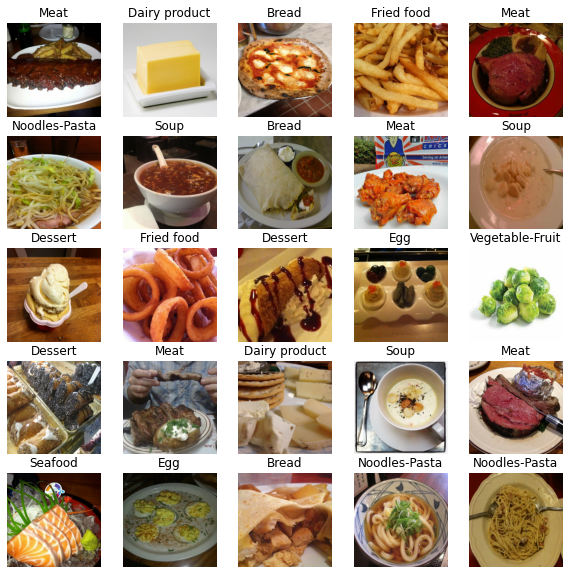

In [6]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(CLASS_NAMES[labels[i]])
        plt.axis("off")

## Dataset distribution

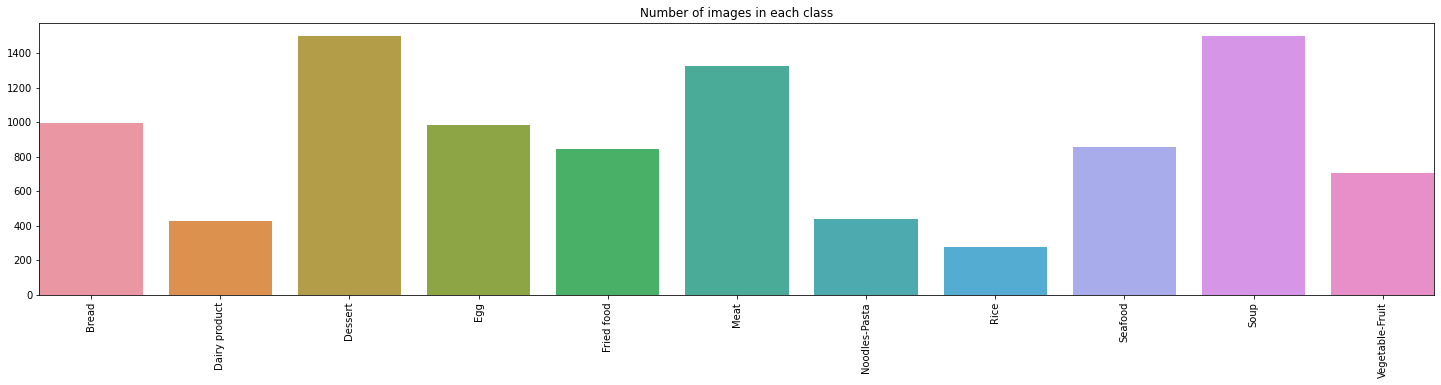

In [7]:
import seaborn as sns

fig = plt.figure(figsize = (25, 5))
sns.barplot(x = list(counts.keys()), y = list(counts.values())).set_title('Number of images in each class')
plt.xticks(rotation = 90)
plt.margins(x=0)
plt.show()

## Image Augmentation

resize image

In [46]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMG_HEIGHT, IMG_WIDTH),
  layers.experimental.preprocessing.Rescaling(1./255)
])

In [8]:
experimental = keras.layers.experimental

img_augmentation = keras.Sequential(
    [
        experimental.preprocessing.RandomRotation(factor=0.2),
        experimental.preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1),
        experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
        experimental.preprocessing.RandomContrast(factor=0.2),
    ],
    name="img_augmentation",
)

Augmentation Result

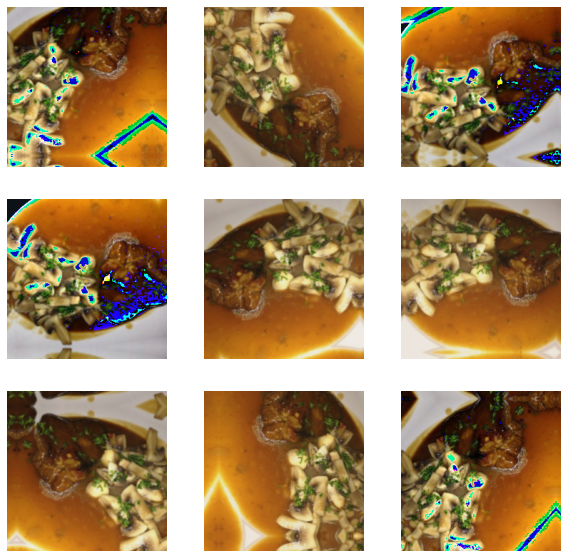

In [9]:
for image, _ in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        aug_img = img_augmentation(tf.expand_dims(image[0], axis=0))
        plt.imshow(aug_img[0].numpy().astype("uint8"))
        plt.axis("off")

## Build Model

In [15]:
img_shape=(IMG_HEIGHT, IMG_WIDTH, 3)

inputs = layers.Input(shape=img_shape)
augmented = img_augmentation(inputs)
base_model = tf.keras.applications.EfficientNetB0(include_top=False, input_tensor=augmented, weights="imagenet")
base_model.trainable = False
base_model.summary()

model = keras.Sequential()

model.add(base_model)
model.add(keras.layers.GlobalAveragePooling2D())

model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Dropout(0.2))

model.add(keras.layers.Dense(1024, activation='relu'))
model.add(keras.layers.Dense(512, activation='relu'))
model.add(keras.layers.Dense(NUM_CLASSES, activation='softmax'))

model.summary()

16711680/16705208 [==============================] - 0s 0us/step
Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
img_augmentation (Sequential)   (None, 224, 224, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
rescaling_2 (Rescaling)         (None, 224, 224, 3)  0           img_augmentation[2][0]           
__________________________________________________________________________________________________
normalization_2 (Normalization) (None, 224, 224, 3)  7           rescaling_2[0][0]                
____________________

In [16]:
model.compile(
    optimizer='adam',
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [17]:
history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=EPOCHS
)

Epoch 1/10
78/78 [==============================] - 65s 735ms/step - loss: 2.4142 - accuracy: 0.5682 - val_loss: 0.7576 - val_accuracy: 0.8111
Epoch 2/10
78/78 [==============================] - 58s 718ms/step - loss: 0.6507 - accuracy: 0.7799 - val_loss: 0.5306 - val_accuracy: 0.8484
Epoch 3/10
78/78 [==============================] - 58s 720ms/step - loss: 0.5607 - accuracy: 0.8156 - val_loss: 0.4764 - val_accuracy: 0.8414
Epoch 4/10
78/78 [==============================] - 58s 716ms/step - loss: 0.5209 - accuracy: 0.8238 - val_loss: 0.4164 - val_accuracy: 0.8653
Epoch 5/10
78/78 [==============================] - 58s 715ms/step - loss: 0.4422 - accuracy: 0.8543 - val_loss: 0.4436 - val_accuracy: 0.8583
Epoch 6/10
78/78 [==============================] - 58s 716ms/step - loss: 0.4187 - accuracy: 0.8535 - val_loss: 0.4373 - val_accuracy: 0.8668
Epoch 7/10
78/78 [==============================] - 58s 715ms/step - loss: 0.3804 - accuracy: 0.8683 - val_loss: 0.4484 - val_accuracy: 0.8624

## Evaluating Performance of Model

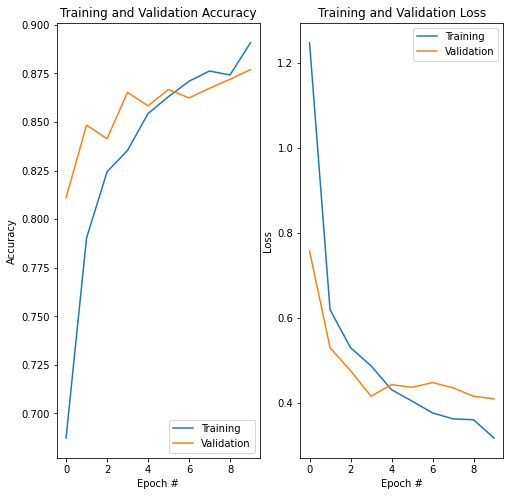

In [18]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training')
plt.plot(epochs_range, val_accuracy, label='Validation')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch #')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training')
plt.plot(epochs_range, val_loss, label='Validation')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch #')
plt.ylabel('Loss')

plt.show()

In [19]:
# Evaluate the performance of the model
evaluate = model.evaluate(
    validation_ds, 
    batch_size=BATCH_SIZE
)

print('Accuracy Test : {}'.format(evaluate[1]))

27/27 [==============================] - 16s 476ms/step - loss: 0.4101 - accuracy: 0.8770
Accuracy Test : 0.8769679069519043


Save model

In [20]:
model.save('trained.h5')

## Prediction

In [21]:
from keras.preprocessing import image

prediction = []
original = []
images = []
path_eval = PATH + '/evaluation'

for i in os.listdir(path_eval):
    for file_name in os.listdir(os.path.join(path_eval, i)):
      # open image from evaluation dir
      img = PIL.Image.open(os.path.join(path_eval, i, file_name))
      # resize image to 224 x 224
      img = img.resize((224,224))
      images.append(img)
      # convert image to numpy array format 
      img_np = image.img_to_array(img)
      img_np = np.expand_dims(img_np, axis=0)
      image_matrix = np.vstack([img_np])
      # making prediction of the model
      result = model.predict(image_matrix, batch_size=10)
      # get the index of the highest value in the prediction
      predict = np.argmax(result[0])
      original.append(i)
      prediction.append(CLASS_NAMES[predict])

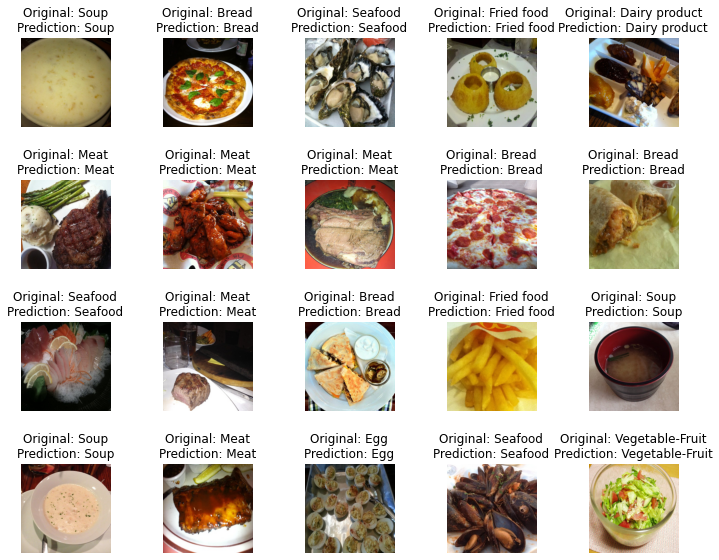

In [22]:
import random

# Visualizing the results
fig=plt.figure(figsize = (10,10))
for i in range(20):
    j = random.randint(0,len(images))
    fig.add_subplot(5, 5, i + 1)
    plt.title("Original: " + original[j] + "\nPrediction: " + prediction[j])
    plt.imshow(images[j])
    plt.axis("off")
fig.tight_layout()
plt.show()